## Figure 2 - SOCS analysis of time-series MERFISH in mouse ovulation
This notebook shows how the panels of Figure 2 in our manuscript (which show the results of using SOCS to estimate differentiation trajectories in mouse ovulation) were generated.

First, we'll import the necessary python modules.

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
import copy
import seaborn as sns
import diffxpy.api as de
from scipy.stats import ttest_ind
import sklearn
import socs
from socs.utils import row_normalize
from socs.analysis import map_vector_sampled,hillNumber_1,vec2vec
from socs.analysis import follicleSize,follicles_to_cells,getInds_g,follicle_average_obs,follicle_edge_dist,follicle_diameters_angles,neighborhood_n_layers_e
import scipy as sp
from scipy.sparse import csr_matrix, save_npz

In [92]:
import torch

In [93]:
print(torch.__version__)

2.5.1+cu124


We'll load in the unprocessed samples, stored as spot-by-genes count tables

In [2]:
adata_1 = sc.read_h5ad('example_data/adata_ovary_0h.h5ad')
adata_2 = sc.read_h5ad('example_data/adata_ovary_4h_r1.h5ad')


We'll filter out cells that have few counts, and normalize and log-transform counts.

In [3]:
sc.pp.filter_cells(adata_1, min_counts=10)
adata_1.layers["counts"] = adata_1.X.copy()
sc.pp.normalize_total(adata_1, inplace=True,target_sum=63)
sc.pp.log1p(adata_1)

In [4]:
sc.pp.filter_cells(adata_2, min_counts=10)
adata_2.layers["counts"] = adata_2.X.copy()
sc.pp.normalize_total(adata_2, inplace=True,target_sum=65)
sc.pp.log1p(adata_2)

We've previously performed cell type labeling on these cells, which we can visualize, as in Fig. 2a:

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


(567.297633031791, 4681.985972863173, -4299.17065825455, -6634.202934855238)

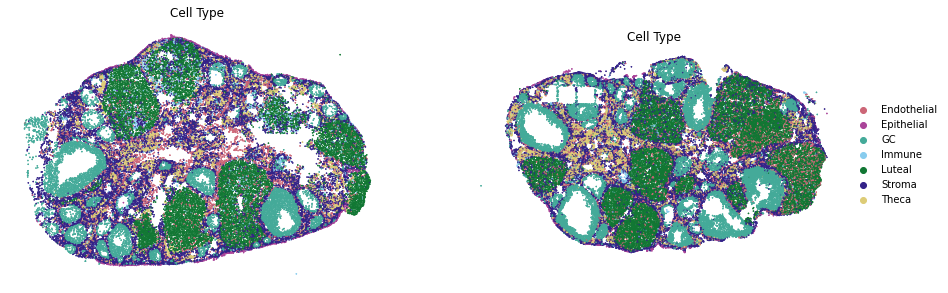

In [5]:
_,axs = plt.subplots(1,2,figsize=[15,9])
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='Cell Type',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=1,
    ax = axs[0]
)
lgd = axs[0].legend()
lgd.remove()
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color='Cell Type',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=1,
    ax = axs[1]
)
axs[0].axis('off')
axs[1].axis('off')

We've also previously labeled the spatially contiguous structures (here, the ovary's follicles and corpora luteum). We can visualize the spatial distribution of these labels.

This visualization shows where in the ovary labeled structures are present, as in Fig. 2b:

(567.297633031791, 4681.985972863173, -4299.17065825455, -6634.202934855238)

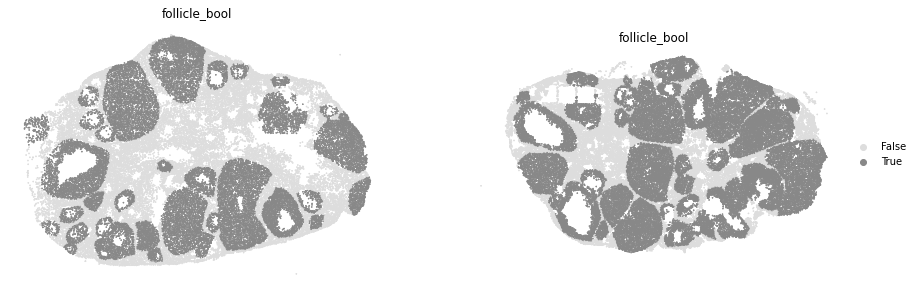

In [6]:
_,axs = plt.subplots(1,2,figsize=[15,7])
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='follicle_bool',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=1,
    ax=axs[0]
)
lgd = axs[0].legend()
lgd.remove()
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color='follicle_bool',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=1,
    ax=axs[1]
)
axs[0].axis('off')
axs[1].axis('off')

This visualization shows the labels of individual structure labels

(567.297633031791, 4681.985972863173, -4299.17065825455, -6634.202934855238)

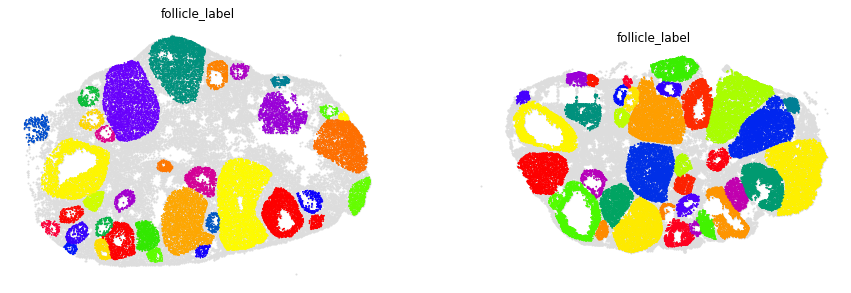

In [7]:
_,axs = plt.subplots(1,2,figsize=[15,7])
axs[0].scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_1[adata_1.obs['follicle_label']!=0,:],
    shape=None,
    color='follicle_label',
    library_id='spatial',
    spatial_key='spatial_sq',
    cmap='prism',
    size=1,
    colorbar=False,
    ax = axs[0],
)
axs[1].scatter(adata_2.obsm['spatial_sq'][:,0],adata_2.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_2[adata_2.obs['follicle_label']!=0,:],
    shape=None,
    color='follicle_label',
    library_id='spatial',
    spatial_key='spatial_sq',
    cmap='prism',
    size=1,
    colorbar=False,
    ax = axs[1],
)
axs[0].axis('off')
axs[1].axis('off')

To focus on the biology of interest (follicle maturation), we filter out cells that do not belong to cell type clusters associated with the follicles (based on a reclustering we've done previously). We'll visualize the remaining cells.

In [8]:
clsts_1 = pd.Series(np.load('example_data/clsts_5_all.npy'))
clsts_2 = pd.Series(np.load('example_data/clsts_2_all.npy'))

inds_follicles = np.where(clsts_1.isin([17,5,15,6,12,10,9,8,21,13,7]))[0]
adata_follicles = adata_1[inds_follicles,:]

inds_follicles_2 = np.where(clsts_2.isin([4,12,14,6,20,16,18,2,5,10,17,3,21]))[0]
adata_follicles_2 = adata_2[inds_follicles_2,:]

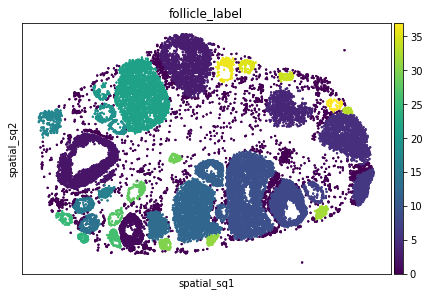

In [22]:
sq.pl.spatial_scatter(
    adata_follicles,
    shape=None,
    color='follicle_label',
    library_id='spatial',
    spatial_key='spatial_sq',
)

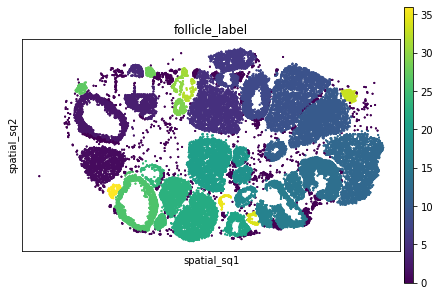

In [23]:
sq.pl.spatial_scatter(
    adata_follicles_2,
    shape=None,
    color='follicle_label',
    library_id='spatial',
    spatial_key='spatial_sq',
)

To further refine, we'll specifically only look at a the set of immature follicles, as defined by a subclustering previously done which we'll load in and use to filter.

In [9]:
clsts_1t = np.load('example_data/clsts_5_medium.npy')
clsts_2t = np.load('example_data/clsts_2_medium.npy')
adata_follicles.obs['clsts'] = pd.Categorical(clsts_1t)
adata_follicles_2.obs['clsts'] = pd.Categorical(clsts_2t)

/local/scratch/48744551.1.interactive/ipykernel_231130/1961190653.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_follicles.obs['clsts'] = pd.Categorical(clsts_1t)
/local/scratch/48744551.1.interactive/ipykernel_231130/1961190653.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_follicles_2.obs['clsts'] = pd.Categorical(clsts_2t)


We can visualize the spatial distribution of these subclusters:

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


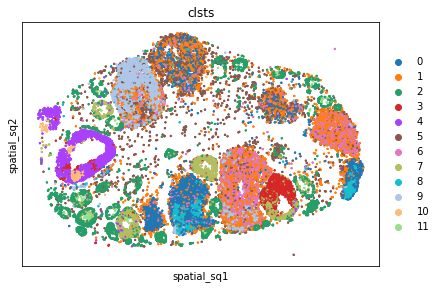

In [14]:
sq.pl.spatial_scatter(
    adata_follicles,
    shape=None,
    color=['clsts'],
    library_id='spatial',
    spatial_key='spatial_sq',
)

We'll select the cells belonging to clusters 2, 7, and 11, which mark the smaller follicles.

In [10]:
adata_imf = adata_follicles[adata_follicles.obs['clsts'].isin([2,7,11]),:]
adata_imf_2 = adata_follicles_2[adata_follicles_2.obs['clsts'].isin([1,10,11]),:]

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


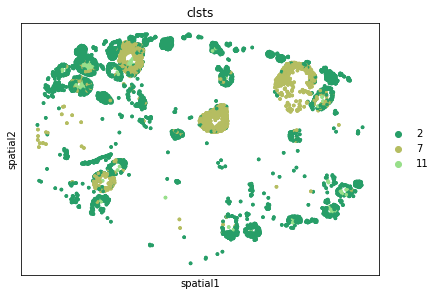

In [16]:
sq.pl.spatial_scatter(
    adata_imf,
    shape=None,
    color=['clsts'],
    library_id='spatial',
    spatial_key='spatial',
)

To clean things up, we'll filter out cells which do not have a follicle label.

In [11]:
adata_n0_imf = adata_imf[adata_imf.obs['follicle_label']!=0,:]
adata_n0_imf_2 = adata_imf_2[adata_imf_2.obs['follicle_label']!=0,:]

We'll further subcluster these immature follicles with unsupervised clustering, dividing into two categories, preantral follicles and small antral follicles. 

In [12]:

sc.tl.pca(adata_n0_imf, svd_solver='arpack',n_comps=50)
sc.pp.neighbors(adata_n0_imf)
sc.tl.umap(adata_n0_imf)
sc.tl.leiden(adata_n0_imf,resolution=0.11)


//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12030. The TBB threading layer is disabled.
  warnings.warn(problem)
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/local/scratch/48744551.1.interactive/ipykernel_231130/682279917.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_n0_imf,resolution=0.11)


In [13]:
sc.tl.pca(adata_n0_imf_2, svd_solver='arpack',n_comps=50)
sc.pp.neighbors(adata_n0_imf_2)
sc.tl.umap(adata_n0_imf_2)
sc.tl.leiden(adata_n0_imf_2,resolution=0.5)

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [14]:
adata_n0_imf.obs['clsts_im_2'] = pd.Categorical(adata_n0_imf.obs['leiden']=='1')
adata_n0_imf.uns['clsts_im_2_colors'] = ['dodgerblue','gold']

In [15]:
adata_n0_imf_2.obs['clsts_im_2'] = pd.Categorical(np.logical_or(adata_n0_imf_2.obs['leiden']=='3',adata_n0_imf_2.obs['leiden']=='4'))
adata_n0_imf_2.uns['clsts_im_2_colors'] = ['dodgerblue','gold']

We'll additionally run through the above steps for the second replicate of the 4h timepoint, to filter down to the small follicles.

In [16]:
adata_3 = sc.read_h5ad('example_data/adata_ovary_4h_r2.h5ad')
adata_3.obsm['spatial_sq'] = copy.deepcopy(adata_3.obsm['spatial'])
adata_3.obsm['spatial_sq'][:,1] = -adata_3.obsm['spatial_sq'][:,1]
sc.pp.filter_cells(adata_3, min_counts=10)
follicle_labels_3 = np.load('example_data/follicle_labels_3.npy')
adata_3.obs['follicle'] = follicle_labels_3
clsts_3 = pd.Series(np.load('example_data/clsts_3_all.npy'))
inds_follicles_3 = np.where(clsts_3.isin([4,12,14,6,20,16,18,2,5,10,17,3,21]))[0]
adata_follicles_3 = adata_3[inds_follicles_3,:]
clsts_3t = np.load('example_data/clsts_3_medium.npy')
adata_follicles_3.obs['clsts'] = clsts_3t
adata_imf_3 = adata_follicles_3[adata_follicles_3.obs['clsts'].isin([1,10,11])]
follicles_4 = np.load('example_data/follicle_labels_3_all.npy')
inds_n0_3 = np.where(follicles_4!=0)[0]
adata_n0_3 = adata_follicles_3[inds_n0_3,:]
adata_n0_imf_3 = adata_n0_3[adata_n0_3.obs['clsts'].isin([1,10,11]),:]
inds_n0_3 = np.where(follicles_4!=0)[0]
adata_n0_raw_3 = adata_follicles_3[inds_n0_3,:]
adata_n0_imf_raw_3 = adata_n0_raw_3[adata_n0_raw_3.obs['clsts'].isin([1,10,11]),:]
clsts_3f = np.load('example_data/clsts_3_small.npy')
adata_n0_imf_raw_3.obs['clsts_im'] = pd.Categorical(clsts_3f)
adata_n0_imf_raw_3.obs['clsts_im_2'] = adata_n0_imf_raw_3.obs['clsts_im']==2
adata_n0_imf_3.obs['clsts_im'] = pd.Categorical(clsts_3f)
adata_n0_imf_3.obs['clsts_im_2'] = pd.Categorical(adata_n0_imf_3.obs['clsts_im']==2)
adata_n0_imf_raw_3.uns['clsts_im_2_colors'] = ['dodgerblue','gold']

/local/scratch/48744551.1.interactive/ipykernel_231130/2151409680.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_follicles_3.obs['clsts'] = clsts_3t
/local/scratch/48744551.1.interactive/ipykernel_231130/2151409680.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_raw_3.obs['clsts_im'] = pd.Categorical(clsts_3f)
/local/scratch/48744551.1.interactive/ipykernel_231130/2151409680.py:23: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_3.obs['clsts_im'] = pd.Categorical(clsts_3f)


We'll visualize the spatial distribution of these cell subtypes, reproducing Fig. 2c.

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


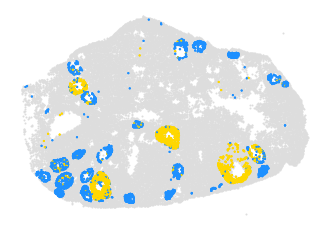

In [28]:
axs = plt.gca()
axs.scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_n0_imf,
    shape=None,
    color='clsts_im_2',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=5,
    ax = axs
)
axs.axis('off')
axs.set_title(None)
axs.get_legend().remove()
plt.savefig('example_data/outputs/figs/cell_types_0h.png')

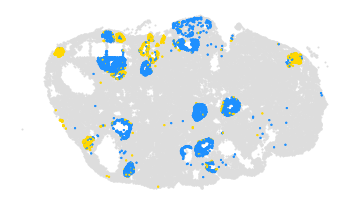

In [30]:
axs = plt.gca()
axs.scatter(adata_2.obsm['spatial_sq'][:,0],adata_2.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_n0_imf_2,
    shape=None,
    color='clsts_im_2',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=5,
    ax = axs
)
axs.axis('off')
axs.set_title(None)
axs.get_legend().remove()
plt.savefig('example_data/outputs/figs/cell_types_4h_1.png')

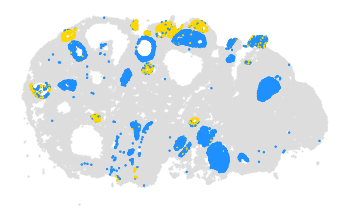

In [39]:
axs = plt.gca()
axs.scatter(adata_3.obsm['spatial_sq'][:,0],adata_3.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_n0_imf_raw_3,
    shape=None,
    color='clsts_im_2',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=5,
    ax = axs
)
axs.axis('off')
axs.set_title(None)
axs.get_legend().remove()
plt.savefig('example_data/outputs/figs/cell_types_4h_2.png')

Now, we'll use SOCS to produce a mapping between the immature follicles in the two time-points.

In [17]:
adata_n0_imf.obs['time'] = 0
adata_n0_imf_2.obs['time'] = 4
adata_c = ad.concat([adata_n0_imf,adata_n0_imf_2])
sc.pp.pca(adata_c, random_state= 0,n_comps=30)
beta_1 = adata_n0_imf.obs['follicle_label']
beta_2 = adata_n0_imf_2.obs['follicle_label']
xy_1 = adata_n0_imf.obsm['spatial']
xy_2 = adata_n0_imf_2.obsm['spatial']

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We'll set up, and run the SOCS problem, with parameters we've chosen.

In [33]:
alpha = 0.7
eps = 1e-2
rho1 = 10.0
rho2 = 10.0
f1 = 5000
f2 = 5000
f_b_1 = 50000
f_b_2 = 55000

socs_model = socs.ot.SOCSModel(adata_c,'time',expr_key='X_pca',struct_key='follicle_label',alpha=alpha,eps=eps,rho=rho1,rho2=rho2,fb0 = f_b_1,fb1 = f_b_2,f0=f1,f1=f2)

In [34]:
T_socs = socs_model.infer_map(0,4)
T_socs_n = row_normalize(T_socs)

We'll save the transport map in a compressed format, to save memory.

In [37]:
T_socs = csr_matrix(T_socs)
save_npz('example_data/T_from_notebook.npz',T_socs)

SOCS can take a while to run - we can also load in a pre-made transport map.

In [66]:
T_socs = np.load('example_data/T_socs.npz')
T_socs = np.array(csr_matrix((T_socs['data'],T_socs['indices'],T_socs['indptr'])).todense())
T_socs_3 = np.load('example_data/T_socs_3.npz')
T_socs_3 = np.array(csr_matrix((T_socs_3['data'],T_socs_3['indices'],T_socs_3['indptr'])).todense()).astype(np.float64)

We'll also load in previously-constructed inferred trajectories produced by Waddington-OT (W-OT) and Moscot.

In [56]:
T_moscot = np.load('example_data/T_moscot.npz')
T_moscot = np.array(csr_matrix((T_moscot['data'],T_moscot['indices'],T_moscot['indptr'])).todense())
T_wot = np.load('example_data/T_wot.npz')
T_wot = np.array(csr_matrix((T_wot['data'],T_wot['indices'],T_wot['indptr'])).todense())

T_moscot_3 = np.load('example_data/T_moscot_3.npz')
T_moscot_3 = np.array(csr_matrix((T_moscot_3['data'],T_moscot_3['indices'],T_moscot_3['indptr'])).todense())
T_wot_3 = np.load('example_data/T_wot_3.npz')
T_wot_3 = np.array(csr_matrix((T_wot_3['data'],T_wot_3['indices'],T_wot_3['indptr'])).todense()).astype(np.float64)

In the next several cells, we'll look at the characteristics of the ovarian follicles. We'll begin by filtering out any follicles with very few cells - these largely are due to follicle segmentation errors.

In [47]:
adata_n0_imf.obs['follicle'] = adata_n0_imf.obs['follicle_label']
adata_n0_imf_2.obs['follicle'] = adata_n0_imf_2.obs['follicle_label']
adata_n0_imf = follicleSize(adata_n0_imf)
adata_n0_imf = follicles_to_cells(adata_n0_imf)
adata_n0_imf_2 = follicleSize(adata_n0_imf_2)
adata_n0_imf_2 = follicles_to_cells(adata_n0_imf_2)
inds_p_src = np.where(adata_n0_imf.obs['follicle_size']>30)[0]
adata_n0_imf_p = adata_n0_imf[inds_p_src,:]
inds_p_tgt = np.where(adata_n0_imf_2.obs['follicle_size']>30)[0]
adata_n0_imf_p_2 = adata_n0_imf_2[inds_p_tgt,:]

/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:458: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_follicle_data[x] = adata.uns['follicles'].loc[adata.obs['follicle'][x]][y]
/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:458: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_follicle_data[x] = adata.uns['follicles'].loc[adata.obs['follicle'][x]][y]


We'll filter the transport maps accordingly, too:

In [48]:
T_p_socs = copy.deepcopy(T_socs)
T_p_socs = T_p_socs[inds_p_src,:]
T_p_socs = T_p_socs[:,inds_p_tgt]
T_p_wot = copy.deepcopy(T_wot)
T_p_wot = T_p_wot[inds_p_src,:]
T_p_wot = T_p_wot[:,inds_p_tgt]
T_p_moscot = copy.deepcopy(T_moscot)
T_p_moscot = T_p_moscot[inds_p_src,:]
T_p_moscot = T_p_moscot[:,inds_p_tgt]

Here, we compute the proportion of the cells belonging to each follicle at 0h which map to each of the follicles at 4h, using the maps generated by SOCS, W-OT, and Moscot. We generate "struct2struct" objects, where element (i,j) represents the proportion of follicle i at 0h which maps to follicle j at 4h.

In [49]:
structs_1 = adata_n0_imf_p.obs['follicle_label']
structs_2 = adata_n0_imf_p_2.obs['follicle_label']
struct2struct = vec2vec(structs_1,structs_2,T_p_socs)
struct2struct_wot = vec2vec(structs_1,structs_2,T_p_wot)
struct2struct_moscot = vec2vec(structs_1,structs_2,T_p_moscot)


/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vec_mapped.append(vec[rx_bin])


KeyboardInterrupt: 

For these "struct2struct" objects, we compute the Hill number of each column, which can be interpreted as the effective number of "ancestor" airways at E14.5 corresponding to each airway at E15.5. 

In [48]:
hn_socs = hillNumber_1(struct2struct)
hn_wot = hillNumber_1(struct2struct_wot)
hn_moscot = hillNumber_1(struct2struct_moscot)

In [49]:
print(np.median(hn_socs))
print(np.median(hn_wot))
print(np.median(hn_moscot))

1.0
12.929283720223001
4.795979595115895


Then, we can visualize the distribution of the effective number of descendant  in a strip plot, comparing the result from the mappings produced by SOCS, W-OT, and Moscot, reproducing Fig. 2d

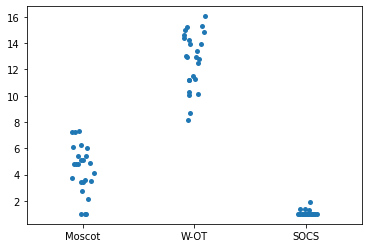

In [50]:
df_m = pd.DataFrame(hn_moscot,columns=['Avg. # of descendants'])
df_m['method'] = 'Moscot'
df_w = pd.DataFrame(hn_wot,columns=['Avg. # of descendants'])
df_w['method'] = 'W-OT'
df_s = pd.DataFrame(hn_socs,columns=['Avg. # of descendants'])
df_s['method'] = 'SOCS'
df_all = pd.concat([df_m,df_w,df_s],axis=0,ignore_index=True)
sns.stripplot(data=df_all,x='method',y='Avg. # of descendants')
ax = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.savefig('example_data/outputs/figs/hill_number_follicles.svg')

We can also compute the proportion of the two cell types at 0h which map to each of the two cell types at 4h, creating "clst2clst" objects, where element (i,j) is the proportion of cells in cluster i at 0h which map to cluster j at 4h.

In [52]:
clsts_1 = adata_n0_imf_p.obs['clsts_im_2'].tolist()
clsts_2 = adata_n0_imf_p_2.obs['clsts_im_2'].tolist()
clst2clst_s = vec2vec(clsts_1,clsts_2,T_p_socs)
clst2clst_w = vec2vec(clsts_1,clsts_2,T_p_wot)
clst2clst_m = vec2vec(clsts_1,clsts_2,T_p_moscot)
clst2clst_n_socs = row_normalize(clst2clst_s)
clst2clst_n_wot = row_normalize(clst2clst_w)
clst2clst_n_moscot = row_normalize(clst2clst_m)


We can then visualize and compare these cell type to cell type mappings with stacked bar charts. This reproduces Fig. 2e.

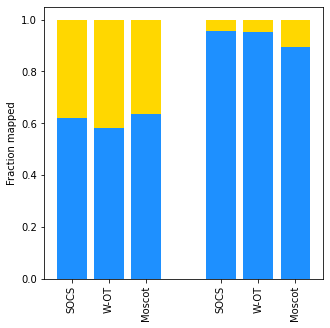

In [53]:
plt.figure(figsize=[5,5])
colors_1 = ["dodgerblue","gold"]
cVal = 0
for y in range(2):
    y=1-y
    yx = y*4
    for x in range(2):
        plt.bar(yx-1,clst2clst_n_socs[y,x],bottom=np.sum(clst2clst_n_socs[y,0:x]),color=colors_1[x])
        plt.bar(yx,clst2clst_n_wot[y,x],bottom=np.sum(clst2clst_n_wot[y,0:x]),color=colors_1[x])
        plt.bar(yx+1,clst2clst_n_moscot[y,x],bottom=np.sum(clst2clst_n_moscot[y,0:x]),color=colors_1[x])

_ = plt.ylabel('Fraction mapped')
_ = plt.xticks([-1,0,1,3,4,5],labels=['SOCS','W-OT','Moscot','SOCS','W-OT','Moscot'],rotation=90)
plt.savefig('example_data/outputs/figs/type2type_ovary.svg')

The functions run in this cell count the number of cells in each follicle.

In [54]:
adata_n0_imf = follicleSize(adata_n0_imf)
adata_n0_imf_2 = follicleSize(adata_n0_imf_2)
adata_n0_imf = follicles_to_cells(adata_n0_imf)
adata_n0_imf_2 = follicles_to_cells(adata_n0_imf_2)

/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:458: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_follicle_data[x] = adata.uns['follicles'].loc[adata.obs['follicle'][x]][y]
/broad/clearylab/Users/Peter/notebooks/socs_f/socs/analysis/analysis.py:458: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_follicle_data[x] = adata.uns['follicles'].loc[adata.obs['follicle'][x]][y]


Here, we set up to run differential expression analysis by defining the variable "condition," which is a binary variable indicating whether a cell maps to a preantral follicle cell or small antral follicle cell.

In [74]:
adata_n0_imf.X = adata_n0_imf.layers['counts'] # Set expression back to raw counts
adata_n0_imf_2.X = adata_n0_imf_2.layers['counts'] 
adata_n0_imf = getInds_g(adata_n0_imf,adata_n0_imf_2,T_socs,'clsts_im_2')
adata_n0_imf = follicle_average_obs(adata_n0_imf,'transport_0')
adata_n0_imf_st = adata_n0_imf[adata_n0_imf.obs['transport_0']!=0,:]
adata_n0_imf_st.obs['condition'] = adata_n0_imf.obs['transport_0']-1
adata_n0_imf_st.X = np.array(adata_n0_imf_t.X.todense())

adata_n0_imf_s_3 = getInds_g(adata_n0_imf,adata_n0_imf_3,T_socs_3,'clsts_im_2')
adata_n0_imf_s_3 = follicle_average_obs(adata_n0_imf_s_3,'transport_0')
adata_n0_imf_st_3 = adata_n0_imf_s_3[adata_n0_imf_s_3.obs['transport_0']!=0,:]
adata_n0_imf_st_3.obs['condition'] = adata_n0_imf_st_3.obs['transport_0']-1
adata_n0_imf_st_3.X = np.array(adata_n0_imf_st_3.X.todense())


/local/scratch/48725954.1.interactive/ipykernel_23950/828126860.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_t.obs['condition'] = adata_n0_imf.obs['transport_0']-1
/local/scratch/48725954.1.interactive/ipykernel_23950/828126860.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_tto3.obs['condition'] = adata_n0_imf_to3.obs['transport_0']-1


In [69]:
adata_n0_imf_w = getInds_g(adata_n0_imf,adata_n0_imf_2,T_wot,'clsts_im_2')
adata_n0_imf_w = follicle_average_obs(adata_n0_imf_w,'transport_0')
adata_n0_imf_wt = adata_n0_imf_w[adata_n0_imf_w.obs['transport_0']!=0,:]
adata_n0_imf_wt.obs['condition'] = adata_n0_imf_w.obs['transport_0']-1
adata_n0_imf_wt.X = np.array(adata_n0_imf_wt.X.todense())

adata_n0_imf_w_3 = getInds_g(adata_n0_imf,adata_n0_imf_3,T_wot_3,'clsts_im_2')
adata_n0_imf_w_3 = follicle_average_obs(adata_n0_imf_w_3,'transport_0')
adata_n0_imf_wt_3 = adata_n0_imf_wto3[adata_n0_imf_w_3.obs['transport_0']!=0,:]
adata_n0_imf_wt_3.obs['condition'] = adata_n0_imf_wt_3.obs['transport_0']-1
adata_n0_imf_wt_3.X = np.array(adata_n0_imf_wt_3.X.todense())

/local/scratch/48725954.1.interactive/ipykernel_23950/805546524.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_wt.obs['condition'] = adata_n0_imf_w.obs['transport_0']-1
/local/scratch/48725954.1.interactive/ipykernel_23950/805546524.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_wtto3.obs['condition'] = adata_n0_imf_wto3.obs['transport_0']-1


In [70]:
adata_n0_imf_m = getInds_g(adata_n0_imf,adata_n0_imf_2,T_moscot,'clsts_im_2')
adata_n0_imf_m = follicle_average_obs(adata_n0_imf_m,'transport_0')
adata_n0_imf_mt = adata_n0_imf_m[adata_n0_imf_m.obs['transport_0']!=0,:]
adata_n0_imf_mt.obs['condition'] = adata_n0_imf_m.obs['transport_0']-1
adata_n0_imf_mt.X = np.array(adata_n0_imf_mt.X.todense())

adata_n0_imf_m_3 = getInds_g(adata_n0_imf,adata_n0_imf_3,T_moscot_3,'clsts_im_2')
adata_n0_imf_m_3 = follicle_average_obs(adata_n0_imf_m+3,'transport_0')
adata_n0_imf_mt_3 = adata_n0_imf_m_3[adata_n0_imf_m_3.obs['transport_0']!=0,:]
adata_n0_imf_mt_3.obs['condition'] = adata_n0_imf_mt_3.obs['transport_0']-1
adata_n0_imf_mt_3.X = np.array(adata_n0_imf_mt_3.X.todense())

/local/scratch/48725954.1.interactive/ipykernel_23950/367151771.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_mt.obs['condition'] = adata_n0_imf_m.obs['transport_0']-1
/local/scratch/48725954.1.interactive/ipykernel_23950/367151771.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_mtto3.obs['condition'] = adata_n0_imf_mto3.obs['transport_0']-1


We can use diffxpy to perform differential expression analysis, comparing the "maturing" preantral follicle cells to the "not maturing" preantral follicle cells.

In [75]:
t2_r = de.test.wald(
    data=adata_n0_imf_st,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=271753.450089
iter   1: ll=271753.450089, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=157436.735760, converged: 0.00% (loc: 0.00%, scale update: True), in 4.68sec
iter   3: ll=157436.735760, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=153821.806131, converged: 90.40% (loc: 90.40%, scale update: True), in 4.27sec
iter   5: ll=153821.806131, converged: 90.40% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=153753.083276, converged: 96.97% (loc: 96.97%, scale update: True), in 1.32sec
iter   7: ll=153753.083276, converged: 96.97% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=153753.083276, converged: 100.00% (loc: 100.00%, scale update: True), in 1.02sec


In [76]:
t2_r3 = de.test.wald(
    data=adata_n0_imf_st_3,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=271796.902801
iter   1: ll=271796.902801, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=154871.663650, converged: 0.00% (loc: 0.00%, scale update: True), in 4.66sec
iter   3: ll=154871.663650, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=154227.410988, converged: 90.40% (loc: 90.40%, scale update: True), in 4.34sec
iter   5: ll=154227.410988, converged: 90.40% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=154147.450613, converged: 96.46% (loc: 96.46%, scale update: True), in 1.37sec
iter   7: ll=154147.450613, converged: 96.46% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=154132.441153, converged: 98.99% (loc: 98.99%, scale update: True), in 1.09sec
iter   9: ll=154132.441153, converged: 98.99% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=154132.441153, converged: 100.00% (loc: 100.00%, scale update: True)

In [77]:
t2_1w = de.test.wald(
    data=adata_n0_imf_wt,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=271938.743696
iter   1: ll=271938.743696, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=154713.750361, converged: 0.00% (loc: 0.00%, scale update: True), in 5.06sec
iter   3: ll=154713.750361, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=153973.825025, converged: 91.41% (loc: 91.41%, scale update: True), in 4.82sec
iter   5: ll=153973.825025, converged: 91.41% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=153943.033419, converged: 96.46% (loc: 96.46%, scale update: True), in 1.28sec
iter   7: ll=153943.033419, converged: 96.46% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=153941.788676, converged: 98.99% (loc: 98.99%, scale update: True), in 1.01sec
iter   9: ll=153941.788676, converged: 98.99% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=153941.788676, converged: 100.00% (loc: 100.00%, scale update: True)

In [78]:
t2_1w3 = de.test.wald(
    data=adata_n0_imf_wt_3,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=271857.494153
iter   1: ll=271857.494153, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=156400.775067, converged: 0.00% (loc: 0.00%, scale update: True), in 4.63sec
iter   3: ll=156400.775067, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=154164.125115, converged: 90.40% (loc: 90.40%, scale update: True), in 4.29sec
iter   5: ll=154164.125115, converged: 90.40% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=154155.524029, converged: 98.48% (loc: 98.48%, scale update: True), in 1.33sec
iter   7: ll=154155.524029, converged: 98.48% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=154155.524029, converged: 100.00% (loc: 100.00%, scale update: True), in 0.21sec


In [79]:
t2_1m = de.test.wald(
    data=adata_n0_imf_mt,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=272071.917228
iter   1: ll=272071.917228, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=154947.882380, converged: 0.00% (loc: 0.00%, scale update: True), in 4.70sec
iter   3: ll=154947.882380, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=154187.443510, converged: 89.39% (loc: 89.39%, scale update: True), in 4.35sec
iter   5: ll=154187.443510, converged: 89.39% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=154136.312245, converged: 96.97% (loc: 96.97%, scale update: True), in 1.47sec
iter   7: ll=154136.312245, converged: 96.97% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=154136.312245, converged: 100.00% (loc: 100.00%, scale update: True), in 1.04sec


In [80]:
t2_1m3 = de.test.wald(
    data=adata_n0_imf_mt_3,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=272202.611166
iter   1: ll=272202.611166, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=155689.385809, converged: 0.00% (loc: 0.00%, scale update: True), in 4.59sec
iter   3: ll=155689.385809, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=154092.430810, converged: 89.90% (loc: 89.90%, scale update: True), in 4.35sec
iter   5: ll=154092.430810, converged: 89.90% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=153976.895070, converged: 97.47% (loc: 97.47%, scale update: True), in 1.42sec
iter   7: ll=153976.895070, converged: 97.47% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=153976.397946, converged: 99.49% (loc: 99.49%, scale update: True), in 1.04sec
iter   9: ll=153976.397946, converged: 99.49% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=153976.397946, converged: 100.00% (loc: 100.00%, scale update: True)

In these next few cells, we'll establish a threshold on the log-fold change in expression for a gene to be considered differentially expressed, and filter out outliers. We'll do this for the mappings produced by all SOCS, W-OT, and Moscot, for both replicates.

In [55]:
fc_t = 1.25
lfc_t = np.log2(fc_t)

In [56]:
logfc_1 = t2_r.log2_fold_change()
inds_lfc_1 = np.where(np.abs(logfc_1)<10)[0]
qval_1 = -t2_r.log10_qval_clean(log10_threshold=-30)
inds_lfc_1t = np.where(np.logical_and(np.abs(logfc_1)<10,np.abs(logfc_1)>lfc_t))[0]


In [57]:
logfc_13 = t2_r3.log2_fold_change()
inds_lfc_13 = np.where(np.abs(logfc_13)<10)[0]
qval_13 = -t2_r3.log10_qval_clean(log10_threshold=-30)
inds_lfc_13t = np.where(np.logical_and(np.abs(logfc_13)<10,np.abs(logfc_13)>lfc_t))[0]


In [58]:
logfc_1w = t2_1w.log2_fold_change()
inds_lfc_1w = np.where(np.abs(logfc_1w)<10)[0]
qval_1w = -t2_1w.log10_qval_clean(log10_threshold=-30)
inds_lfc_1wt = np.where(np.logical_and(np.abs(logfc_1w)<10,np.abs(logfc_1w)>lfc_t))[0]


In [59]:
logfc_1w3 = t2_1w3.log2_fold_change()
inds_lfc_1w3 = np.where(np.abs(logfc_1w3)<10)[0]
qval_1w3 = -t2_1w3.log10_qval_clean(log10_threshold=-30)
inds_lfc_1wt3 = np.where(np.logical_and(np.abs(logfc_1w3)<10,np.abs(logfc_1w3)>lfc_t))[0]


In [60]:
logfc_1m = t2_1m.log2_fold_change()
inds_lfc_1m = np.where(np.abs(logfc_1m)<10)[0]
qval_1m = -t2_1m.log10_qval_clean(log10_threshold=-30)
inds_lfc_1mt = np.where(np.logical_and(np.abs(logfc_1m)<10,np.abs(logfc_1m)>lfc_t))[0]


In [61]:
logfc_1m3 = t2_1m3.log2_fold_change()
inds_lfc_1m3 = np.where(np.abs(logfc_1m3)<10)[0]
qval_1m3 = -t2_1m3.log10_qval_clean(log10_threshold=-30)
inds_lfc_1mt3 = np.where(np.logical_and(np.abs(logfc_1m3)<10,np.abs(logfc_1m3)>lfc_t))[0]


Here, we find the set of genes that are consistently differentially expressed, in both replicates, in the same direction.

In [81]:
inds_lfc = np.where(np.logical_and(np.abs(logfc_1)<10,np.abs(logfc_13)<10))[0]
inds_lfc_t = np.where(np.logical_and(np.logical_and(np.abs(logfc_1)<10,np.abs(logfc_1)>lfc_t),np.logical_and(logfc_13<10,np.abs(logfc_13)>lfc_t)))[0]
inds_qt1 = np.where(qval_1[inds_lfc_t]>qval_t)[0]
inds_qt13 = np.where(qval_13[inds_lfc_t]>qval_t)[0]
print(len(np.where(qval_1[inds_lfc_1]>qval_t)[0]))
print(len(np.where(qval_13[inds_lfc_13]>qval_t)[0]))
inds_up_q1 = np.where(np.logical_and(logfc_1[inds_lfc_t][inds_qt1]>0,logfc_13[inds_lfc_t][inds_qt1]>0))[0]
inds_down_q1 = np.where(np.logical_and(logfc_1[inds_lfc_t][inds_qt1]<0,logfc_13[inds_lfc_t][inds_qt1]<0))[0]
inds_up_q13 = np.where(np.logical_and(logfc_1[inds_lfc_t][inds_qt13]>0,logfc_13[inds_lfc_t][inds_qt13]>0))[0]
inds_down_q13 = np.where(np.logical_and(logfc_1[inds_lfc_t][inds_qt13]<0,logfc_13[inds_lfc_t][inds_qt13]<0))[0]
s_up_q1 = set([inds_qt1[x] for x in inds_up_q1])
s_down_q1 = set([inds_qt1[x] for x in inds_down_q1])
s_up_q13 = set([inds_qt13[x] for x in inds_up_q13])
s_down_q13 = set([inds_qt13[x] for x in inds_down_q13])
s_up_i = s_up_q1.intersection(s_up_q13)
s_down_i = s_down_q1.intersection(s_down_q13)
print(len(inds_up_q1)+len(inds_down_q1))
print(len(inds_up_q13)+len(inds_down_q13))
print(len(s_up_i)+len(s_down_i))

NameError: name 'logfc_1' is not defined

Here we'll sort the list of differentially expressed genes by log-fold change, and save this list as a csv file.

In [65]:
inds_up_i = inds_lfc_t[list(s_up_i)]
inds_down_i = inds_lfc_t[list(s_down_i)]
ainds_up = np.argsort(-logfc_1[inds_up_i])
ainds_down = np.argsort(-logfc_1[inds_down_i])
geneNames_up = [adata_1.var_names.tolist()[inds_up_i[ainds_up[x]]] for x in range(len(ainds_up))]
lfc_up = [2**logfc_1[inds_up_i[ainds_up[x]]] for x in range(len(ainds_up))]
qvals_up = [qval_1[inds_up_i[ainds_up[x]]] for x in range(len(ainds_up))]
geneNames_down = [adata_1.var_names.tolist()[inds_down_i[ainds_down[x]]] for x in range(len(ainds_down))]
lfc_down = [-2**-logfc_1[inds_down_i[ainds_down[x]]] for x in range(len(ainds_down))]
qvals_down = [qval_1[inds_down_i[ainds_down[x]]] for x in range(len(ainds_down))]

In [66]:
df_up = pd.DataFrame(geneNames_up,columns=['gene name'])
df_up['lfc'] = lfc_up
df_up['qval'] = qvals_up
df_down = pd.DataFrame(geneNames_down,columns=['gene name'])
df_down['lfc'] = lfc_down
df_down['qval'] = qvals_down
df_lfc = pd.concat([df_up,df_down])

In [68]:
df_lfc.to_csv('example_data/outputs/degs/df_lfc_1.25_v4.csv')


We can visualize these differentially expressed genes with volcano plots. These reproduce Fig. 2f

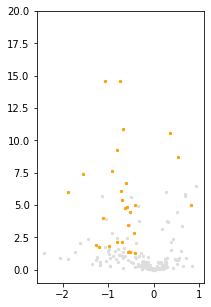

In [70]:
plt.figure(figsize=[3,5])
qval_t = -np.log10(0.05)
plt.scatter(logfc_1[inds_lfc_1],qval_1[inds_lfc_1],s=5,c="#DDDDDD")
plt.scatter(logfc_1[inds_up_i],qval_1[inds_up_i],s=5,c='orange')
plt.scatter(logfc_1[inds_down_i],qval_1[inds_down_i],s=5,c='orange')
ax = plt.gca()
plt.ylim([-1,20])
plt.savefig('example_data/outputs/figs/degs_socs_1.25_v4.svg')

We'll repeat the above steps for the W-OT mapping DEGs

In [73]:
inds_lfc_w = np.where(np.logical_and(np.abs(logfc_1w)<10,np.abs(logfc_1w3)<10))[0]
inds_lfc_wt = np.where(np.logical_and(np.logical_and(np.abs(logfc_1w)<10,np.abs(logfc_1w)>lfc_t),np.logical_and(logfc_1w3<10,np.abs(logfc_1w3)>lfc_t)))[0]
inds_qt1_w = np.where(qval_1w[inds_lfc_wt]>qval_t)[0]
inds_qt13_w = np.where(qval_1w3[inds_lfc_wt]>qval_t)[0]
print(len(np.where(qval_1w[inds_lfc_1w]>qval_t)[0]))
print(len(np.where(qval_1w3[inds_lfc_1w3]>qval_t)[0]))
inds_up_q1_w = np.where(np.logical_and(logfc_1w[inds_lfc_wt][inds_qt1_w]>0,logfc_1w3[inds_lfc_wt][inds_qt1_w]>0))[0]
inds_down_q1_w = np.where(np.logical_and(logfc_1w[inds_lfc_wt][inds_qt1_w]<0,logfc_1w3[inds_lfc_wt][inds_qt1_w]<0))[0]
inds_up_q13_w = np.where(np.logical_and(logfc_1w[inds_lfc_wt][inds_qt13_w]>0,logfc_1w3[inds_lfc_wt][inds_qt13_w]>0))[0]
inds_down_q13_w = np.where(np.logical_and(logfc_1w[inds_lfc_wt][inds_qt13_w]<0,logfc_1w3[inds_lfc_wt][inds_qt13_w]<0))[0]
s_up_q1_w = set([inds_qt1_w[x] for x in inds_up_q1_w])
s_down_q1_w = set([inds_qt1_w[x] for x in inds_down_q1_w])
s_up_q13_w = set([inds_qt13_w[x] for x in inds_up_q13_w])
s_down_q13_w = set([inds_qt13_w[x] for x in inds_down_q13_w])
s_up_i_w = s_up_q1_w.intersection(s_up_q13_w)
s_down_i_w = s_down_q1_w.intersection(s_down_q13_w)
print(len(inds_up_q1_w)+len(inds_down_q1_w))
print(len(inds_up_q13_w)+len(inds_down_q13_w))
print(len(s_up_i_w)+len(s_down_i_w))

65
65
0.11013775151315601
1.0
31
32
28


In [74]:
inds_up_i_w = inds_lfc_wt[list(s_up_i_w)]
inds_down_i_w = inds_lfc_wt[list(s_down_i_w)]
ainds_up_w = np.argsort(-logfc_1w[inds_up_i_w])
ainds_down_w = np.argsort(-logfc_1w[inds_down_i_w])
geneNames_up_w = [adata_1.var_names.tolist()[inds_up_i_w[ainds_up_w[x]]] for x in range(len(ainds_up_w))]
lfc_up_w = [2**logfc_1w[inds_up_i_w[ainds_up_w[x]]] for x in range(len(ainds_up_w))]
qvals_up_w = [qval_1w[inds_up_i_w[ainds_up_w[x]]] for x in range(len(ainds_up_w))]
geneNames_down_w = [adata_1.var_names.tolist()[inds_down_i_w[ainds_down_w[x]]] for x in range(len(ainds_down_w))]
lfc_down_w = [-2**-logfc_1w[inds_down_i_w[ainds_down_w[x]]] for x in range(len(ainds_down_w))]
qvals_down_w = [qval_1w[inds_down_i_w[ainds_down_w[x]]] for x in range(len(ainds_down_w))]

In [75]:
df_up_w = pd.DataFrame(geneNames_up_w,columns=['gene name'])
df_up_w['lfc'] = lfc_up_w
df_up_w['qval'] = qvals_up_w
df_down_w = pd.DataFrame(geneNames_down_w,columns=['gene name'])
df_down_w['lfc'] = lfc_down_w
df_down_w['qval'] = qvals_down_w
df_lfc_w = pd.concat([df_up_w,df_down_w])

In [76]:
df_lfc_w.to_csv('example_data/outputs/degs/df_lfc_1.25_wot_v4.csv')

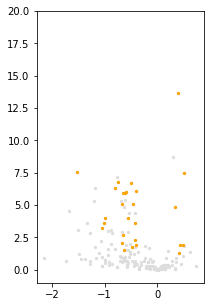

In [77]:
plt.figure(figsize=[3,5])
qval_t = -np.log10(0.05)
plt.scatter(logfc_1w[inds_lfc_1w],qval_1w[inds_lfc_1w],s=5,c="#DDDDDD")
plt.scatter(logfc_1w[inds_up_i_w],qval_1w[inds_up_i_w],s=5,c='orange')
plt.scatter(logfc_1w[inds_down_i_w],qval_1w[inds_down_i_w],s=5,c='orange')
ax = plt.gca()
plt.ylim([-1,20])
plt.savefig('example_data/outputs/figs/degs_wot_v4.svg')

We'll again repeat the same steps for the Moscot mapping DEGs

In [80]:
inds_lfc_m = np.where(np.logical_and(np.abs(logfc_1m)<10,np.abs(logfc_1m3)<10))[0]
inds_lfc_mt = np.where(np.logical_and(np.logical_and(np.abs(logfc_1m)<10,np.abs(logfc_1m)>lfc_t),np.logical_and(logfc_1m3<10,np.abs(logfc_1m3)>lfc_t)))[0]
inds_qt1_m = np.where(qval_1m[inds_lfc_mt]>qval_t)[0]
inds_qt13_m = np.where(qval_1m3[inds_lfc_mt]>qval_t)[0]
print(len(np.where(qval_1m[inds_lfc_1m]>qval_t)[0]))
print(len(np.where(qval_1m3[inds_lfc_1m3]>qval_t)[0]))
inds_up_q1_m = np.where(np.logical_and(logfc_1m[inds_lfc_mt][inds_qt1_m]>0,logfc_1m3[inds_lfc_mt][inds_qt1_m]>0))[0]
inds_down_q1_m = np.where(np.logical_and(logfc_1m[inds_lfc_mt][inds_qt1_m]<0,logfc_1m3[inds_lfc_mt][inds_qt1_m]<0))[0]
inds_up_q13_m = np.where(np.logical_and(logfc_1m[inds_lfc_mt][inds_qt13_m]>0,logfc_1m3[inds_lfc_mt][inds_qt13_m]>0))[0]
inds_down_q13_m = np.where(np.logical_and(logfc_1m[inds_lfc_mt][inds_qt13_m]<0,logfc_1m3[inds_lfc_mt][inds_qt13_m]<0))[0]
s_up_q1_m = set([inds_qt1_m[x] for x in inds_up_q1_m])
s_down_q1_m = set([inds_qt1_m[x] for x in inds_down_q1_m])
s_up_q13_m = set([inds_qt13_m[x] for x in inds_up_q13_m])
s_down_q13_m = set([inds_qt13_m[x] for x in inds_down_q13_m])
s_up_i_m = s_up_q1_m.intersection(s_up_q13_m)
s_down_i_m = s_down_q1_m.intersection(s_down_q13_m)
print(len(inds_up_q1_m)+len(inds_down_q1_m))
print(len(inds_up_q13_m)+len(inds_down_q13_m))
print(len(s_up_i_m)+len(s_down_i_m))

28
30
0.144892695937961
1.0
6
9
4


In [81]:
inds_up_i_m = inds_lfc_mt[list(s_up_i_m)]
inds_down_i_m = inds_lfc_mt[list(s_down_i_m)]
ainds_up_m = np.argsort(-logfc_1m[inds_up_i_m])
ainds_down_m = np.argsort(-logfc_1m[inds_down_i_m])
geneNames_up_m = [adata_1.var_names.tolist()[inds_up_i_m[ainds_up_m[x]]] for x in range(len(ainds_up_m))]
lfc_up_m = [2**logfc_1w[inds_up_i_m[ainds_up_m[x]]] for x in range(len(ainds_up_m))]
qvals_up_m = [qval_1w[inds_up_i_m[ainds_up_m[x]]] for x in range(len(ainds_up_m))]
geneNames_down_m = [adata_1.var_names.tolist()[inds_down_i_m[ainds_down_m[x]]] for x in range(len(ainds_down_m))]
lfc_down_m = [-2**-logfc_1m[inds_down_i_m[ainds_down_m[x]]] for x in range(len(ainds_down_m))]
qvals_down_m = [qval_1m[inds_down_i_m[ainds_down_m[x]]] for x in range(len(ainds_down_m))]

In [82]:
df_up_m = pd.DataFrame(geneNames_up_m,columns=['gene name'])
df_up_m['lfc'] = lfc_up_m
df_up_m['qval'] = qvals_up_m
df_down_m = pd.DataFrame(geneNames_down_m,columns=['gene name'])
df_down_m['lfc'] = lfc_down_m
df_down_m['qval'] = qvals_down_m
df_lfc_m = pd.concat([df_up_m,df_down_m])

In [83]:
df_lfc_m.to_csv('example_data/outputs/degs/df_lfc_1.25_moscot_v4.csv')

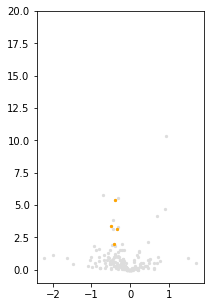

In [84]:
plt.figure(figsize=[3,5])
qval_t = -np.log10(0.05)
plt.scatter(logfc_1m[inds_lfc_1m],qval_1m[inds_lfc_1m],s=5,c="#DDDDDD")
plt.scatter(logfc_1m[inds_up_i_m],qval_1m[inds_up_i_m],s=5,c='orange')
plt.scatter(logfc_1m[inds_down_i_m],qval_1m[inds_down_i_m],s=5,c='orange')
ax = plt.gca()
plt.ylim([-1,20])
plt.savefig('example_data/outputs/figs/degs_moscot_v4.svg')

Now, let's look at the follicles as a unit. We can compare the mapping methods by visualizing the spatial distribution of preantral follicle cells that are inferred by the map to be "maturing" and "not-maturing."

We start by filtering out certain follicles

In [ ]:
adata_n0_imf_s_f = follicle_average_obs(adata_n0_imf_s,'transport_0')
adata_n0_imf_s_f = follicles_to_cells(adata_n0_imf_s_f)
inds_f_s = np.where(adata_n0_imf_s_f.obs['follicle_avg_transport_0']>0.5)[0]
adata_n0_imf_s_f = adata_n0_imf_s_f[inds_f_s,:]
adata_n0_imf_w_f = follicle_average_obs(adata_n0_imf_w,'transport_0')
adata_n0_imf_w_f = follicles_to_cells(adata_n0_imf_w_f)
inds_f_w = np.where(adata_n0_imf_w_f.obs['follicle_avg_transport_0']>0.5)[0]
adata_n0_imf_w_f = adata_n0_imf_w_f[inds_f_w,:]
adata_n0_imf_m_f = follicle_average_obs(adata_n0_imf_m,'transport_0')
adata_n0_imf_m_f = follicles_to_cells(adata_n0_imf_m_f)
inds_f_m = np.where(adata_n0_imf_m_f.obs['follicle_avg_transport_0']>0.5)[0]
adata_n0_imf_m_f = adata_n0_imf_m_f[inds_f_m,:]

In [ ]:
adata_n0_imf_s_f_3 = follicle_average_obs(adata_n0_imf_s_3,'transport_0')
adata_n0_imf_s_f_3 = follicles_to_cells(adata_n0_imf_s_f_3)
inds_f_s_3 = np.where(adata_n0_imf_s_f_3.obs['follicle_avg_transport_0']>0.5)[0]
adata_n0_imf_s_f_3 = adata_n0_imf_s_f_3[inds_f_s_3,:]
adata_n0_imf_w_f_3 = follicle_average_obs(adata_n0_imf_w_3,'transport_0')
adata_n0_imf_w_f_3 = follicles_to_cells(adata_n0_imf_w_f_3)
inds_f_w_3 = np.where(adata_n0_imf_w_f_3.obs['follicle_avg_transport_0']>0.5)[0]
adata_n0_imf_w_f_3 = adata_n0_imf_w_f_3[inds_f_w_3,:]
adata_n0_imf_m_f_3 = follicle_average_obs(adata_n0_imf_m_3,'transport_0')
adata_n0_imf_m_f_3 = follicles_to_cells(adata_n0_imf_m_f_3)
inds_f_m_3 = np.where(adata_n0_imf_m_f_3.obs['follicle_avg_transport_0']>0.5)[0]
adata_n0_imf_m_f_3 = adata_n0_imf_m_f_3[inds_f_m_3,:]

We'll also filter out any follicles with fewer than 30 cells.

In [ ]:
adata_n0_imf_st_p = follicleSize(adata_n0_imf_s_f)
adata_n0_imf_st_p = follicles_to_cells(adata_n0_imf_st_p)
inds_p_st = np.where(adata_n0_imf_st_p.obs['follicle_size']>30)[0]
adata_n0_imf_st_p = adata_n0_imf_st_p[inds_p_st,:]
adata_n0_imf_wt_p = follicleSize(adata_n0_imf_w_f)
adata_n0_imf_wt_p = follicles_to_cells(adata_n0_imf_wt_p)
inds_p_wt = np.where(adata_n0_imf_wt_p.obs['follicle_size']>30)[0]
adata_n0_imf_wt_p = adata_n0_imf_wt_p[inds_p_wt,:]
adata_n0_imf_mt_p = follicleSize(adata_n0_imf_m_f)
adata_n0_imf_mt_p = follicles_to_cells(adata_n0_imf_mt_p)
inds_p_mt = np.where(adata_n0_imf_mt_p.obs['follicle_size']>30)[0]
adata_n0_imf_mt_p = adata_n0_imf_mt_p[inds_p_mt,:]

adata_n0_imf_st_p_3 = follicleSize(adata_n0_imf_s_f_3)
adata_n0_imf_st_p_3 = follicles_to_cells(adata_n0_imf_st_p_3)
inds_p_st_3 = np.where(adata_n0_imf_st_p_3.obs['follicle_size']>30)[0]
adata_n0_imf_st_p_3 = adata_n0_imf_st_p_3[inds_p_st_3,:]
adata_n0_imf_wt_p_3 = follicleSize(adata_n0_imf_w_f_3)
adata_n0_imf_wt_p_3 = follicles_to_cells(adata_n0_imf_wt_p_3)
inds_p_wt_3 = np.where(adata_n0_imf_wt_p_3.obs['follicle_size']>30)[0]
adata_n0_imf_wt_p_3 = adata_n0_imf_wt_p_3[inds_p_wt_3,:]
adata_n0_imf_mt_p_3 = follicleSize(adata_n0_imf_m_f_3)
adata_n0_imf_mt_p_3 = follicles_to_cells(adata_n0_imf_mt_p_3)
inds_p_mt_3 = np.where(adata_n0_imf_mt_p_3.obs['follicle_size']>30)[0]
adata_n0_imf_mt_p_3 = adata_n0_imf_mt_p_3[inds_p_mt_3,:]



Then we'll set up a few plotting parameters.

In [98]:
adata_n0_imf_st_p.obs['condition_c'] = pd.Categorical(adata_n0_imf_st_p.obs['condition'])
adata_n0_imf_wt_p.obs['condition_c'] = pd.Categorical(adata_n0_imf_wt_p.obs['condition'])
adata_n0_imf_mt_p.obs['condition_c'] = pd.Categorical(adata_n0_imf_mt_p.obs['condition'])
adata_n0_imf_st_p.uns['condition_c_colors'] = ['#FDD700','#008B8B'] 
adata_n0_imf_wt_p.uns['condition_c_colors'] = ['#FDD700','#008B8B'] 
adata_n0_imf_mt_p.uns['condition_c_colors'] = ['#FDD700','#008B8B']  

/local/scratch/46704585.1.interactive/ipykernel_133267/95145882.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_st_p.obs['condition_c'] = pd.Categorical(adata_n0_imf_st_p.obs['condition'])
/local/scratch/46704585.1.interactive/ipykernel_133267/95145882.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_wt_p.obs['condition_c'] = pd.Categorical(adata_n0_imf_wt_p.obs['condition'])
/local/scratch/46704585.1.interactive/ipykernel_133267/95145882.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_n0_imf_mt_p.obs['condition_c'] = pd.Categorical(adata_n0_imf_mt_p.obs['condition'])


Here we map the distribution of maturing and not-maturing preantral follicle cells, as estimated by SOCS. These visualizations will reproduce Fig. 2g.

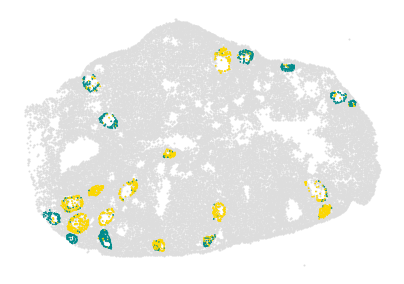

In [102]:
plt.figure(figsize=[7,7])
axs = plt.gca()
axs.scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_n0_imf_st_p,
    shape=None,
    color='condition_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs,
    size=1
)
axs.axis('off')
axs.set_title(None)
axs.get_legend().remove()
plt.savefig('example_data/outputs/figs/follicles_transport_socs.png')

Here we produce this spatial distribution, as estimated by Moscot.

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


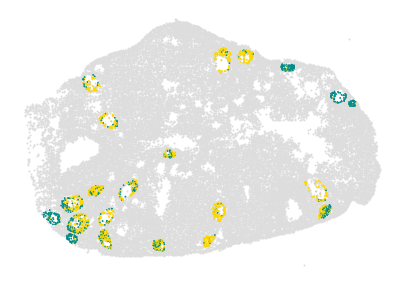

In [100]:
plt.figure(figsize=[7,7])
axs = plt.gca()
axs.scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_n0_imf_mt_p,
    shape=None,
    color='condition_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=1,
    ax = axs
)
axs.axis('off')
axs.set_title(None)
axs.get_legend().remove()
plt.savefig('example_data/outputs/figs/follicles_transport_moscot.png')

Finally we produce this spatial distribution, as estimated by W-OT.

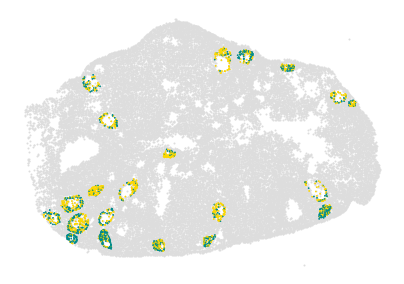

In [101]:
plt.figure(figsize=[7,7])
axs = plt.gca()
axs.scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=1,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_n0_imf_wt_p,
    shape=None,
    color='condition_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=1,
    ax=axs
)
axs.axis('off')
axs.set_title(None)
axs.get_legend().remove()
plt.savefig('example_data/outputs/figs/follicles_transport_wot.png')

In [103]:
_ = adata_n0_imf_st_p.uns.pop('follicles')
_ = adata_n0_imf_wt_p.uns.pop('follicles')
_ = adata_n0_imf_mt_p.uns.pop('follicles')

Now, with the SOCS mapping it is visually clear which follicles can be considered "maturing" follicles as a whole. To quantify this, we label follicles wherein at least 80% of the cells are maturing to be "maturing follicles", and follicles wherein at least 80% of the cells are not maturing to be "not maturing follicles."

In [106]:
pct = 0.8
inds_pt_n0_t1_u = adata_n0_imf_st_p.uns['follicles']['avg_transport_0']>(1.0+pct)
inds_pt_n0_t2_u = np.logical_and(adata_n0_imf_st_p.uns['follicles']['avg_transport_0']>1.0,adata_n0_imf_st_p.uns['follicles']['avg_transport_0']<(2.0-pct))
inds_pt_n0_t_u = np.where(np.logical_or(inds_pt_n0_t1_u,inds_pt_n0_t2_u))[0]
adata_n0_imf_st_p.uns['follicles'] = adata_n0_imf_st_p.uns['follicles'].iloc[inds_pt_n0_t_u,:]


Having labeled the follicles, we can compute various morphological metrics, including follicle diameter and distance to the edge of the ovary.

In [104]:
adata_n0_imf_st_p = follicle_edge_dist(adata_n0_imf_st_p,[5])
adata_n0_imf_st_p = follicle_diameters_angles(adata_n0_imf_st_p)
adata_n0_imf_st_p = follicle_average_obs(adata_n0_imf_st_p,'transport_0')

In [105]:
adata_n0_imf_st_p.obs['t_1_t'] = adata_n0_imf_st_p.obs['follicle_avg_transport_0']>1.5
adata_n0_imf_st_p = follicle_average_obs(adata_n0_imf_st_p,'t_1_t')

In [107]:
df_f1 = adata_n0_imf_st_p.uns['follicles']
df_f1['target'] = np.ones([df_f1.shape[0],])*1

We can compare the maturing and not-maturing follicles with these morphological metrics, and visualize these with strip-plots. These figures reproduce Fig. 2h.

112.35633941999026
104.60453324697605
113.84310722132439
92.1874798386122
26.48116312127864
22.710774225200307
TtestResult(statistic=1.7588211663280136, pvalue=0.09789729632183955, df=15.848296876970295)


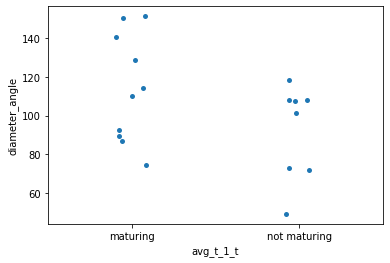

In [108]:
obs_var = 'diameter_angle'
data_st = df_f1

sns.stripplot(data=data_st,x='avg_t_1_t',y=obs_var)

ax = plt.gca()
ax.set_xticks(np.arange(2),labels=['maturing','not maturing'])
data_n = data_st[obs_var][data_st['avg_t_1_t']==False]
data_p = data_st[obs_var][data_st['avg_t_1_t']==True]

print(np.nanmedian(data_n))
print(np.nanmedian(data_p))
print(np.nanmean(data_n))
print(np.nanmean(data_p))
print(np.std(data_n))
print(np.std(data_p))
print(ttest_ind(data_n, data_p, equal_var = False, nan_policy='omit'))
plt.savefig('example_data/outputs/figs/diameter_stripplot.svg')

247.45206143104693
74.00352020635088
294.9944171626045
112.62757685882964
209.1511791246377
116.50209745123182
TtestResult(statistic=2.211615297769845, pvalue=0.04336543899162933, df=14.621263491727689)


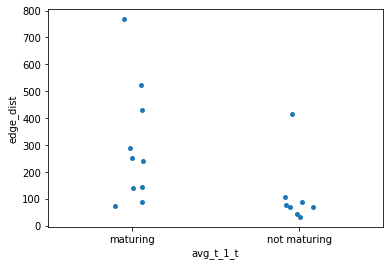

In [109]:
obs_var = 'edge_dist'
data_st = df_f1

sns.stripplot(data=data_st,x='avg_t_1_t',y=obs_var)

ax = plt.gca()
ax.set_xticks(np.arange(2),labels=['maturing','not maturing'])
data_n = data_st[obs_var][data_st['avg_t_1_t']==False]
data_p = data_st[obs_var][data_st['avg_t_1_t']==True]

print(np.nanmedian(data_n))
print(np.nanmedian(data_p))
print(np.nanmean(data_n))
print(np.nanmean(data_p))
print(np.std(data_n))
print(np.std(data_p))
print(ttest_ind(data_n, data_p, equal_var = False, nan_policy='omit'))
plt.savefig('example_data/outputs/figs/edgedist_stripplot.svg')

### Neighborhood Analysis
In the following cells, we compare the cells which are neighbors of the maturing and not-maturing preantral follicle cells.

First, we get the x-y coordinates of the preantral follicle cells, and divide based on whether they map to preantral follicles or small antral follicles.

In [110]:
xy_1 = adata_1.obsm['spatial']
xy_n0_imf_st_p = adata_n0_imf_st_p.obsm['spatial']
xy_n0_imf_st_p_1 = adata_n0_imf_st_p[adata_n0_imf_st_p.obs['transport_0']==2,:].obsm['spatial']
xy_n0_imf_st_p_2 = adata_n0_imf_st_p[adata_n0_imf_st_p.obs['transport_0']==1,:].obsm['spatial']
xy_n0_imf_wt_p = adata_n0_imf_wt_p.obsm['spatial']
xy_n0_imf_wt_p_1 = adata_n0_imf_wt_p[adata_n0_imf_wt_p.obs['transport_0']==2,:].obsm['spatial']
xy_n0_imf_wt_p_2 = adata_n0_imf_wt_p[adata_n0_imf_wt_p.obs['transport_0']==1,:].obsm['spatial']
xy_n0_imf_mt_p = adata_n0_imf_mt_p.obsm['spatial']
xy_n0_imf_mt_p_1 = adata_n0_imf_mt_p[adata_n0_imf_mt_p.obs['transport_0']==2,:].obsm['spatial']
xy_n0_imf_mt_p_2 = adata_n0_imf_mt_p[adata_n0_imf_mt_p.obs['transport_0']==1,:].obsm['spatial']

xy_n0_imf_st_p_3 = adata_n0_imf_st_p_3.obsm['spatial']
xy_n0_imf_st_p_3_1 = adata_n0_imf_st_p_3[adata_n0_imf_st_p_3.obs['transport_0']==2,:].obsm['spatial']
xy_n0_imf_st_p_3_2 = adata_n0_imf_st_p_3[adata_n0_imf_st_p_3.obs['transport_0']==1,:].obsm['spatial']
xy_n0_imf_wt_p_3 = adata_n0_imf_wt_p_3.obsm['spatial']
xy_n0_imf_wt_p_3_1 = adata_n0_imf_wt_p_3[adata_n0_imf_wt_p_3.obs['transport_0']==2,:].obsm['spatial']
xy_n0_imf_wt_p_3_2 = adata_n0_imf_wt_p_3[adata_n0_imf_wt_p_3.obs['transport_0']==1,:].obsm['spatial']
xy_n0_imf_mt_p_3 = adata_n0_imf_mt_p_3.obsm['spatial']
xy_n0_imf_mt_p_3_1 = adata_n0_imf_mt_p_3[adata_n0_imf_mt_p_3.obs['transport_0']==2,:].obsm['spatial']
xy_n0_imf_mt_p_3_2 = adata_n0_imf_mt_p_3[adata_n0_imf_mt_p_3.obs['transport_0']==1,:].obsm['spatial']

Here, we use the neighborhood_n_layers_e function to use Delaunay triangulation to find the neighbors of maturing and not-maturing preantral follicle cells, according to the SOCS, W-OT, and Moscot mappings.

In [111]:
layers_st_pt_1 = neighborhood_n_layers_e(xy_n0_imf_st_p_1,xy_1,xy_n0_imf_st_p,2,20)
layers_st_pt_2 = neighborhood_n_layers_e(xy_n0_imf_st_p_2,xy_1,xy_n0_imf_st_p,2,20)
layers_wt_pt_1 = neighborhood_n_layers_e(xy_n0_imf_wt_p_1,xy_1,xy_n0_imf_wt_p,2,20)
layers_wt_pt_2 = neighborhood_n_layers_e(xy_n0_imf_wt_p_2,xy_1,xy_n0_imf_wt_p,2,20)
layers_mt_pt_1 = neighborhood_n_layers_e(xy_n0_imf_mt_p_1,xy_1,xy_n0_imf_mt_p,2,20)
layers_mt_pt_2 = neighborhood_n_layers_e(xy_n0_imf_mt_p_2,xy_1,xy_n0_imf_mt_p,2,20)

layers_st_pt_3_1 = neighborhood_n_layers_e(xy_n0_imf_st_p_3_1,xy_1,xy_n0_imf_st_p_3,2,20)
layers_st_pt_3_2 = neighborhood_n_layers_e(xy_n0_imf_st_p_3_2,xy_1,xy_n0_imf_st_p_3,2,20)
layers_wt_pt_3_1 = neighborhood_n_layers_e(xy_n0_imf_wt_p_3_1,xy_1,xy_n0_imf_wt_p_3,2,20)
layers_wt_pt_3_2 = neighborhood_n_layers_e(xy_n0_imf_wt_p_3_2,xy_1,xy_n0_imf_wt_p_3,2,20)
layers_mt_pt_3_1 = neighborhood_n_layers_e(xy_n0_imf_mt_p_3_1,xy_1,xy_n0_imf_mt_p_3,2,20)
layers_mt_pt_3_2 = neighborhood_n_layers_e(xy_n0_imf_mt_p_3_2,xy_1,xy_n0_imf_mt_p_3,2,20)

We add the vector representation of neighborhood status to the anndata object representing all cells at 0h.

In [112]:
adata_1.obs['layers_st_pt_1'] = layers_st_pt_1
adata_1.obs['layers_st_pt_2'] = layers_st_pt_2
adata_1.obs['layers_wt_pt_1'] = layers_wt_pt_1
adata_1.obs['layers_wt_pt_2'] = layers_wt_pt_2
adata_1.obs['layers_mt_pt_1'] = layers_mt_pt_1
adata_1.obs['layers_mt_pt_2'] = layers_mt_pt_2

adata_1.obs['layers_st_pt_3_1'] = layers_st_pt_3_1
adata_1.obs['layers_st_pt_3_2'] = layers_st_pt_3_2
adata_1.obs['layers_wt_pt_3_1'] = layers_wt_pt_3_1
adata_1.obs['layers_wt_pt_3_2'] = layers_wt_pt_3_2
adata_1.obs['layers_mt_pt_3_1'] = layers_mt_pt_3_1
adata_1.obs['layers_mt_pt_3_2'] = layers_mt_pt_3_2

From there, we get anndata objects which only contain cells which are neighbors of the maturing an not-maturing preantral follicle cells, for SOCS, W-OT, and Moscot. 

In [113]:
adata_st_nt1 = adata_1[adata_1.obs['layers_st_pt_1']<=2,:]
adata_st_nt1 = adata_st_nt1[adata_st_nt1.obs['layers_st_pt_1']!=0,:]
adata_st_nt2 = adata_1[adata_1.obs['layers_st_pt_2']<=2,:]
adata_st_nt2 = adata_st_nt2[adata_st_nt2.obs['layers_st_pt_2']!=0,:]
adata_wt_nt1 = adata_1[adata_1.obs['layers_wt_pt_1']<=2,:]
adata_wt_nt1 = adata_wt_nt1[adata_wt_nt1.obs['layers_wt_pt_1']!=0,:]
adata_wt_nt2 = adata_1[adata_1.obs['layers_wt_pt_2']<=2,:]
adata_wt_nt2 = adata_wt_nt2[adata_wt_nt2.obs['layers_wt_pt_2']!=0,:]
adata_mt_nt1 = adata_1[adata_1.obs['layers_mt_pt_1']<=2,:]
adata_mt_nt1 = adata_mt_nt1[adata_mt_nt1.obs['layers_mt_pt_1']!=0,:]
adata_mt_nt2 = adata_1[adata_1.obs['layers_mt_pt_2']<=2,:]
adata_mt_nt2 = adata_mt_nt2[adata_mt_nt2.obs['layers_mt_pt_2']!=0,:]

adata_st_nt1_3 = adata_1[adata_1.obs['layers_st_pt_3_1']<=2,:]
adata_st_nt1_3 = adata_st_nt1_3[adata_st_nt1_3.obs['layers_st_pt_3_1']!=0,:]
adata_st_nt2_3 = adata_1[adata_1.obs['layers_st_pt_3_2']<=2,:]
adata_st_nt2_3 = adata_st_nt2_3[adata_st_nt2_3.obs['layers_st_pt_3_2']!=0,:]
adata_wt_nt1_3 = adata_1[adata_1.obs['layers_wt_pt_3_1']<=2,:]
adata_wt_nt1_3 = adata_wt_nt1_3[adata_wt_nt1_3.obs['layers_wt_pt_3_1']!=0,:]
adata_wt_nt2_3 = adata_1[adata_1.obs['layers_wt_pt_3_2']<=2,:]
adata_wt_nt2_3 = adata_wt_nt2_3[adata_wt_nt2_3.obs['layers_wt_pt_3_2']!=0,:]
adata_mt_nt1_3 = adata_1[adata_1.obs['layers_mt_pt_3_1']<=2,:]
adata_mt_nt1_3 = adata_mt_nt1_3[adata_mt_nt1_3.obs['layers_mt_pt_3_1']!=0,:]
adata_mt_nt2_3 = adata_1[adata_1.obs['layers_mt_pt_3_2']<=2,:]
adata_mt_nt2_3 = adata_mt_nt2_3[adata_mt_nt2_3.obs['layers_mt_pt_3_2']!=0,:]

We specifically focus on the cells which belong to the Stroma annotated cell type in our differential expression analysis, so we select those.

In [114]:
de_type = 'Stroma'
adata_st_nt1_t = adata_st_nt1[adata_st_nt1.obs['Cell Type']==de_type,:]
adata_st_nt2_t = adata_st_nt2[adata_st_nt2.obs['Cell Type']==de_type,:]
adata_st_n_t = ad.concat([adata_st_nt1_t,adata_st_nt2_t],label='condition')
adata_wt_nt1_t = adata_wt_nt1[adata_wt_nt1.obs['Cell Type']==de_type,:]
adata_wt_nt2_t = adata_wt_nt2[adata_wt_nt2.obs['Cell Type']==de_type,:]
adata_wt_n_t = ad.concat([adata_wt_nt1_t,adata_wt_nt2_t],label='condition')
adata_mt_nt1_t = adata_mt_nt1[adata_mt_nt1.obs['Cell Type']==de_type,:]
adata_mt_nt2_t = adata_mt_nt2[adata_mt_nt2.obs['Cell Type']==de_type,:]
adata_mt_n_t = ad.concat([adata_mt_nt1_t,adata_mt_nt2_t],label='condition')

adata_st_nt1_t_3 = adata_st_nt1_3[adata_st_nt1_3.obs['Cell Type']==de_type,:]
adata_st_nt2_t_3 = adata_st_nt2_3[adata_st_nt2_3.obs['Cell Type']==de_type,:]
adata_st_n_t_3 = ad.concat([adata_st_nt1_t_3,adata_st_nt2_t_3],label='condition')
adata_wt_nt1_t_3 = adata_wt_nt1_3[adata_wt_nt1_3.obs['Cell Type']==de_type,:]
adata_wt_nt2_t_3 = adata_wt_nt2_3[adata_wt_nt2_3.obs['Cell Type']==de_type,:]
adata_wt_n_t_3 = ad.concat([adata_wt_nt1_t_3,adata_wt_nt2_t_3],label='condition')
adata_mt_nt1_t_3 = adata_mt_nt1_3[adata_mt_nt1_3.obs['Cell Type']==de_type,:]
adata_mt_nt2_t_3 = adata_mt_nt2_3[adata_mt_nt2_3.obs['Cell Type']==de_type,:]
adata_mt_n_t_3 = ad.concat([adata_mt_nt1_t_3,adata_mt_nt2_t_3],label='condition')


//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
//broad/clearyla

In [115]:
adata_st_n_t.X = np.array(adata_st_n_t.layers['counts'].todense())
adata_wt_n_t.X = np.array(adata_wt_n_t.layers['counts'].todense())
adata_mt_n_t.X = np.array(adata_mt_n_t.layers['counts'].todense())

adata_st_n_t_3.X = np.array(adata_st_n_t_3.layers['counts'].todense())
adata_wt_n_t_3.X = np.array(adata_wt_n_t_3.layers['counts'].todense())
adata_mt_n_t_3.X = np.array(adata_mt_n_t_3.layers['counts'].todense())

Now we use the diffxpy function to perform differential expression analysis, for the estimates produced by SOCS, W-OT, and Moscot, on both 4h replicates 

In [116]:
t2_st_1 = de.test.wald(
    data=adata_st_n_t,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=336018.251342
iter   1: ll=336018.251342, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=148907.777483, converged: 3.03% (loc: 3.03%, scale update: True), in 2.66sec
iter   3: ll=148907.777483, converged: 3.03% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=145813.233240, converged: 82.83% (loc: 82.83%, scale update: True), in 2.33sec
iter   5: ll=145813.233240, converged: 82.83% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=145212.953242, converged: 90.91% (loc: 90.91%, scale update: True), in 0.88sec
iter   7: ll=145212.953242, converged: 90.91% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=145119.408547, converged: 97.98% (loc: 97.98%, scale update: True), in 0.66sec
iter   9: ll=145119.408547, converged: 97.98% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=145119.335176, converged: 99.49% (loc: 99.49%, scale update: True), 

In [117]:
t2_st_2 = de.test.wald(
    data=adata_st_n_t_3,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=336718.544326
iter   1: ll=336718.544326, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=146326.593523, converged: 3.03% (loc: 3.03%, scale update: True), in 2.52sec
iter   3: ll=146326.593523, converged: 3.03% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=144692.640745, converged: 83.33% (loc: 83.33%, scale update: True), in 2.35sec
iter   5: ll=144692.640745, converged: 83.33% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=144316.690546, converged: 93.43% (loc: 93.43%, scale update: True), in 0.92sec
iter   7: ll=144316.690546, converged: 93.43% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=144082.375264, converged: 98.48% (loc: 98.48%, scale update: True), in 0.57sec
iter   9: ll=144082.375264, converged: 98.48% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=144082.375264, converged: 100.00% (loc: 100.00%, scale update: True)

In [118]:
t2_wt_1 = de.test.wald(
    data=adata_wt_n_t,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=417317.864015
iter   1: ll=417317.864015, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=182078.619405, converged: 3.03% (loc: 3.03%, scale update: True), in 2.92sec
iter   3: ll=182078.619405, converged: 3.03% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=179604.519115, converged: 85.86% (loc: 85.86%, scale update: True), in 2.62sec
iter   5: ll=179604.519115, converged: 85.86% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=179109.823564, converged: 96.46% (loc: 96.46%, scale update: True), in 0.89sec
iter   7: ll=179109.823564, converged: 96.46% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=178866.557066, converged: 98.48% (loc: 98.48%, scale update: True), in 0.55sec
iter   9: ll=178866.557066, converged: 98.48% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=178866.557066, converged: 100.00% (loc: 100.00%, scale update: True)

In [119]:
t2_wt_2 = de.test.wald(
    data=adata_wt_n_t_3,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=441903.886664
iter   1: ll=441903.886664, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=170318.013454, converged: 3.03% (loc: 3.03%, scale update: True), in 2.75sec
iter   3: ll=170318.013454, converged: 3.03% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=168756.363400, converged: 79.29% (loc: 79.29%, scale update: True), in 2.52sec
iter   5: ll=168756.363400, converged: 79.29% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=167667.089534, converged: 87.88% (loc: 87.88%, scale update: True), in 1.03sec
iter   7: ll=167667.089534, converged: 87.88% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=167647.296291, converged: 98.99% (loc: 98.99%, scale update: True), in 0.79sec
iter   9: ll=167647.296291, converged: 98.99% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=167647.296291, converged: 100.00% (loc: 100.00%, scale update: True)

In [120]:
t2_mt_1 = de.test.wald(
    data=adata_mt_n_t,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=407627.002837
iter   1: ll=407627.002837, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=168367.790251, converged: 3.54% (loc: 3.54%, scale update: True), in 2.73sec
iter   3: ll=168367.790251, converged: 3.54% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=165980.083206, converged: 83.84% (loc: 83.84%, scale update: True), in 2.45sec
iter   5: ll=165980.083206, converged: 83.84% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=165778.845698, converged: 95.96% (loc: 95.96%, scale update: True), in 0.89sec
iter   7: ll=165778.845698, converged: 95.96% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=165642.134995, converged: 97.47% (loc: 97.47%, scale update: True), in 0.56sec
iter   9: ll=165642.134995, converged: 97.47% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=165642.134995, converged: 100.00% (loc: 100.00%, scale update: True)

In [121]:
t2_mt_2 = de.test.wald(
    data=adata_mt_n_t_3,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

training location model: False
training scale model: True
iter   0: ll=386006.545929
iter   1: ll=386006.545929, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=156710.943437, converged: 3.03% (loc: 3.03%, scale update: True), in 2.60sec
iter   3: ll=156710.943437, converged: 3.03% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=153432.225600, converged: 84.85% (loc: 84.85%, scale update: True), in 2.36sec
iter   5: ll=153432.225600, converged: 84.85% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=152877.326584, converged: 93.43% (loc: 93.43%, scale update: True), in 0.83sec
iter   7: ll=152877.326584, converged: 93.43% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=152805.784352, converged: 98.48% (loc: 98.48%, scale update: True), in 0.59sec
iter   9: ll=152805.784352, converged: 98.48% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=152805.784352, converged: 100.00% (loc: 100.00%, scale update: True)

We establish a threshold on log-fold change, and identify significantly differentiall expressed genes

In [122]:
fc_t = 1.25
lfc_t = np.log2(fc_t)
logfc_1_s = t2_st_1.log2_fold_change()
inds_lfc_1_s = np.where(np.abs(logfc_1_s)<10)[0]
qval_1_s = -t2_st_1.log10_qval_clean(log10_threshold=-30)
inds_lfc_1t_s = np.where(np.logical_and(np.abs(logfc_1_s)<10,np.abs(logfc_1_s)>lfc_t))[0]

logfc_2_s = t2_st_2.log2_fold_change()
inds_lfc_2_s = np.where(np.abs(logfc_2_s)<10)[0]
qval_2_s = -t2_st_2.log10_qval_clean(log10_threshold=-30)
inds_lfc_2t_s = np.where(np.logical_and(np.abs(logfc_2_s)<10,np.abs(logfc_2_s)>lfc_t))[0]


In [123]:
logfc_1_w = t2_wt_1.log2_fold_change()
inds_lfc_1_w = np.where(np.abs(logfc_1_w)<10)[0]
qval_1_w = -t2_wt_1.log10_qval_clean(log10_threshold=-30)
inds_lfc_1t_w = np.where(np.logical_and(np.abs(logfc_1_w)<10,np.abs(logfc_1_w)>lfc_t))[0]

logfc_2_w = t2_wt_2.log2_fold_change()
inds_lfc_2_w = np.where(np.abs(logfc_2_w)<10)[0]
qval_2_w = -t2_wt_2.log10_qval_clean(log10_threshold=-30)
inds_lfc_2t_w = np.where(np.logical_and(np.abs(logfc_2_w)<10,np.abs(logfc_2_w)>lfc_t))[0]

In [124]:
logfc_1_m = t2_mt_1.log2_fold_change()
inds_lfc_1_m = np.where(np.abs(logfc_1_m)<10)[0]
qval_1_m = -t2_mt_1.log10_qval_clean(log10_threshold=-30)
inds_lfc_1t_m = np.where(np.logical_and(np.abs(logfc_1_m)<10,np.abs(logfc_1_m)>lfc_t))[0]

logfc_2_m = t2_mt_2.log2_fold_change()
inds_lfc_2_m = np.where(np.abs(logfc_2_m)<10)[0]
qval_2_m = -t2_mt_2.log10_qval_clean(log10_threshold=-30)
inds_lfc_2t_m = np.where(np.logical_and(np.abs(logfc_2_m)<10,np.abs(logfc_2_m)>lfc_t))[0]

We identify genes which are significantly differentially expressed in the same direction in both replicates, as estimated by the SOCS map.

In [126]:
inds_lfc_sm = np.where(np.logical_and(np.abs(logfc_1_s)<10,np.abs(logfc_2_s)<10))[0]
inds_lfc_smt = np.where(np.logical_and(np.logical_and(np.abs(logfc_1_s)<10,np.abs(logfc_1_s)>lfc_t),np.logical_and(logfc_2_s<10,np.abs(logfc_2_s)>lfc_t)))[0]
inds_qt1_sm = np.where(qval_1_s[inds_lfc_smt]>qval_t)[0]
inds_qt2_sm = np.where(qval_2_s[inds_lfc_smt]>qval_t)[0]
print(len(np.where(qval_1_s[inds_lfc_1_s]>qval_t)[0]))
print(len(np.where(qval_2_s[inds_lfc_2_s]>qval_t)[0]))
inds_up_q1_s = np.where(np.logical_and(logfc_1_s[inds_lfc_smt][inds_qt1_sm]>0,logfc_2_s[inds_lfc_smt][inds_qt1_sm]>0))[0]
inds_down_q1_s = np.where(np.logical_and(logfc_1_s[inds_lfc_smt][inds_qt1_sm]<0,logfc_2_s[inds_lfc_smt][inds_qt1_sm]<0))[0]
inds_up_q2_s = np.where(np.logical_and(logfc_1_s[inds_lfc_smt][inds_qt2_sm]>0,logfc_2_s[inds_lfc_smt][inds_qt2_sm]>0))[0]
inds_down_q2_s = np.where(np.logical_and(logfc_1_s[inds_lfc_smt][inds_qt2_sm]<0,logfc_2_s[inds_lfc_smt][inds_qt2_sm]<0))[0]
s_up_q1_s = set([inds_qt1_sm[x] for x in inds_up_q1_s])
s_down_q1_s = set([inds_qt1_sm[x] for x in inds_down_q1_s])
s_up_q2_s = set([inds_qt2_sm[x] for x in inds_up_q2_s])
s_down_q2_s = set([inds_qt2_sm[x] for x in inds_down_q2_s])
s_up_i_sm = s_up_q1_s.intersection(s_up_q2_s)
s_down_i_sm = s_down_q1_s.intersection(s_down_q2_s)
print(len(inds_up_q1_s)+len(inds_down_q1_s))
print(len(inds_up_q2_s)+len(inds_down_q2_s))
print(len(s_up_i_sm)+len(s_down_i_sm))

16
16
0.9603504792749445
1.0
10
11
9


We sort the DEGs by log-fold change, and save the list.

In [127]:
inds_up_i_sm = inds_lfc_smt[list(s_up_i_sm)]
inds_down_i_sm = inds_lfc_smt[list(s_down_i_sm)]
ainds_up_sm = np.argsort(-logfc_1_s[inds_up_i_sm])
ainds_down_sm = np.argsort(-logfc_1_s[inds_down_i_sm])
geneNames_up_sm = [adata_1.var_names.tolist()[inds_up_i_sm[ainds_up_sm[x]]] for x in range(len(ainds_up_sm))]
lfc_up_sm = [2**logfc_1_s[inds_up_i_sm[ainds_up_sm[x]]] for x in range(len(ainds_up_sm))]
qvals_up_sm = [qval_1_s[inds_up_i_sm[ainds_up_sm[x]]] for x in range(len(ainds_up_sm))]
geneNames_down_sm = [adata_1.var_names.tolist()[inds_down_i_sm[ainds_down_sm[x]]] for x in range(len(ainds_down_sm))]
lfc_down_sm = [-2**-logfc_1_s[inds_down_i_sm[ainds_down_sm[x]]] for x in range(len(ainds_down_sm))]
qvals_down_sm = [qval_1_s[inds_down_i_sm[ainds_down_sm[x]]] for x in range(len(ainds_down_sm))]

In [128]:
df_up_sm = pd.DataFrame(geneNames_up_sm,columns=['gene name'])
df_up_sm['lfc'] = lfc_up_sm
df_up_sm['qval'] = qvals_up_sm
df_down_sm = pd.DataFrame(geneNames_down_sm,columns=['gene name'])
df_down_sm['lfc'] = lfc_down_sm
df_down_sm['qval'] = qvals_down_sm
df_lfc_sm = pd.concat([df_up_sm,df_down_sm])

In [129]:
df_lfc_sm.to_csv('example_data/outputs/degs/df_lfc_1.25_sm_nbrs.csv')


We visualize these differentially expressed genes with a volcano plot. This reproduces the SOCS panel of Fig. 2i

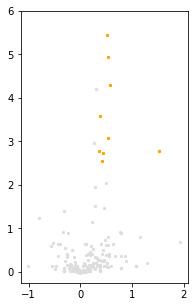

In [130]:
plt.figure(figsize=[3,5])
qval_t = -np.log10(0.05)
plt.scatter(logfc_1_s[inds_lfc_1_s],qval_1_s[inds_lfc_1_s],s=5,c="#DDDDDD")
plt.scatter(logfc_1_s[inds_up_i_sm],qval_1_s[inds_up_i_sm],s=5,c='orange')
plt.scatter(logfc_1_s[inds_down_i_sm],qval_1_s[inds_down_i_sm],s=5,c='orange')
ax = plt.gca()
plt.ylim([-0.25,6])
plt.savefig('example_data/outputs/figs/degs_nbrs_socs.svg')

We repeat the above steps for the map produced by W-OT.

In [132]:
inds_lfc_wm = np.where(np.logical_and(np.abs(logfc_1_w)<10,np.abs(logfc_2_w)<10))[0]
inds_lfc_wmt = np.where(np.logical_and(np.logical_and(np.abs(logfc_1_w)<10,np.abs(logfc_1_w)>lfc_t),np.logical_and(logfc_2_w<10,np.abs(logfc_2_w)>lfc_t)))[0]
inds_qt1_wm = np.where(qval_1_w[inds_lfc_wmt]>qval_t)[0]
inds_qt2_wm = np.where(qval_2_w[inds_lfc_wmt]>qval_t)[0]
print(len(np.where(qval_1_w[inds_lfc_1_w]>qval_t)[0]))
print(len(np.where(qval_2_w[inds_lfc_2_w]>qval_t)[0]))
print(np.corrcoef(logfc_1_w[inds_lfc_wmt][inds_qt1_wm],logfc_2_w[inds_lfc_wmt][inds_qt1_wm])[0,1])
print(np.corrcoef(logfc_2_w[inds_lfc_wmt][inds_qt2_wm],logfc_2_w[inds_lfc_wmt][inds_qt2_wm])[0,1])
inds_up_q1_w = np.where(np.logical_and(logfc_1_w[inds_lfc_wmt][inds_qt1_wm]>0,logfc_2_w[inds_lfc_wmt][inds_qt1_wm]>0))[0]
inds_down_q1_w = np.where(np.logical_and(logfc_1_w[inds_lfc_wmt][inds_qt1_wm]<0,logfc_2_w[inds_lfc_wmt][inds_qt1_wm]<0))[0]
inds_up_q2_w = np.where(np.logical_and(logfc_1_w[inds_lfc_wmt][inds_qt2_wm]>0,logfc_2_w[inds_lfc_wmt][inds_qt2_wm]>0))[0]
inds_down_q2_w = np.where(np.logical_and(logfc_1_w[inds_lfc_wmt][inds_qt2_wm]<0,logfc_2_w[inds_lfc_wmt][inds_qt2_wm]<0))[0]
s_up_q1_w = set([inds_qt1_wm[x] for x in inds_up_q1_w])
s_down_q1_w = set([inds_qt1_wm[x] for x in inds_down_q1_w])
s_up_q2_w = set([inds_qt2_wm[x] for x in inds_up_q2_w])
s_down_q2_w = set([inds_qt2_wm[x] for x in inds_down_q2_w])
s_up_i_wm = s_up_q1_w.intersection(s_up_q2_w)
s_down_i_wm = s_down_q1_w.intersection(s_down_q2_w)
print(len(inds_up_q1_w)+len(inds_down_q1_w))
print(len(inds_up_q2_w)+len(inds_down_q2_w))
print(len(s_up_i_wm)+len(s_down_i_wm))

2
12
nan
0.9999999999999998
0
2
0


//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [133]:
inds_up_i_wm = inds_lfc_wmt[list(s_up_i_wm)]
inds_down_i_wm = inds_lfc_wmt[list(s_down_i_wm)]
ainds_up_wm = np.argsort(-logfc_1_w[inds_up_i_wm])
ainds_down_wm = np.argsort(-logfc_1_w[inds_down_i_wm])
geneNames_up_wm = [adata_1.var_names.tolist()[inds_up_i_wm[ainds_up_wm[x]]] for x in range(len(ainds_up_wm))]
lfc_up_wm = [2**logfc_1_w[inds_up_i_wm[ainds_up_wm[x]]] for x in range(len(ainds_up_wm))]
qvals_up_wm = [qval_1_w[inds_up_i_wm[ainds_up_wm[x]]] for x in range(len(ainds_up_wm))]
geneNames_down_wm = [adata_1.var_names.tolist()[inds_down_i_wm[ainds_down_wm[x]]] for x in range(len(ainds_down_wm))]
lfc_down_wm = [-2**-logfc_1_w[inds_down_i_wm[ainds_down_wm[x]]] for x in range(len(ainds_down_wm))]
qvals_down_wm = [qval_1_w[inds_down_i_wm[ainds_down_wm[x]]] for x in range(len(ainds_down_wm))]

We visualize differential expression with a volcano plot, reproducing the W-OT panel of Fig. 2i

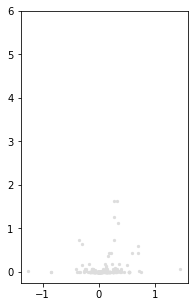

In [134]:
plt.figure(figsize=[3,5])
qval_t = -np.log10(0.05)
plt.scatter(logfc_1_w[inds_lfc_1_w],qval_1_w[inds_lfc_1_w],s=5,c="#DDDDDD")
plt.scatter(logfc_1_w[inds_up_i_wm],qval_1_w[inds_up_i_wm],s=5,c='orange')
plt.scatter(logfc_1_w[inds_down_i_wm],qval_1_w[inds_down_i_wm],s=5,c='orange')
ax = plt.gca()
plt.ylim([-0.25,6])
plt.savefig('example_data/outputs/figs/degs_nbrs_wot.svg')

We again repeat these steps for the maps produced by Moscot.

In [136]:
inds_lfc_mm = np.where(np.logical_and(np.abs(logfc_1_m)<10,np.abs(logfc_2_m)<10))[0]
inds_lfc_mmt = np.where(np.logical_and(np.logical_and(np.abs(logfc_1_m)<10,np.abs(logfc_1_m)>lfc_t),np.logical_and(logfc_2_m<10,np.abs(logfc_2_m)>lfc_t)))[0]
inds_qt1_mm = np.where(qval_1_m[inds_lfc_mmt]>qval_t)[0]
inds_qt2_mm = np.where(qval_2_m[inds_lfc_mmt]>qval_t)[0]
print(len(np.where(qval_1_m[inds_lfc_1_m]>qval_t)[0]))
print(len(np.where(qval_2_m[inds_lfc_2_m]>qval_t)[0]))
print(np.corrcoef(logfc_1_m[inds_lfc_mmt][inds_qt1_mm],logfc_2_w[inds_lfc_mmt][inds_qt1_mm])[0,1])
print(np.corrcoef(logfc_2_m[inds_lfc_mmt][inds_qt2_mm],logfc_2_w[inds_lfc_mmt][inds_qt2_mm])[0,1])
inds_up_q1_m = np.where(np.logical_and(logfc_1_m[inds_lfc_mmt][inds_qt1_mm]>0,logfc_2_m[inds_lfc_mmt][inds_qt1_mm]>0))[0]
inds_down_q1_m = np.where(np.logical_and(logfc_1_m[inds_lfc_mmt][inds_qt1_mm]<0,logfc_2_m[inds_lfc_mmt][inds_qt1_mm]<0))[0]
inds_up_q2_m = np.where(np.logical_and(logfc_1_m[inds_lfc_mmt][inds_qt2_mm]>0,logfc_2_m[inds_lfc_mmt][inds_qt2_mm]>0))[0]
inds_down_q2_m = np.where(np.logical_and(logfc_1_m[inds_lfc_mmt][inds_qt2_mm]<0,logfc_2_m[inds_lfc_mmt][inds_qt2_mm]<0))[0]
s_up_q1_m = set([inds_qt1_mm[x] for x in inds_up_q1_m])
s_down_q1_m = set([inds_qt1_mm[x] for x in inds_down_q1_m])
s_up_q2_m = set([inds_qt2_mm[x] for x in inds_up_q2_m])
s_down_q2_m = set([inds_qt2_mm[x] for x in inds_down_q2_m])
s_up_i_mm = s_up_q1_m.intersection(s_up_q2_m)
s_down_i_mm = s_down_q1_m.intersection(s_down_q2_m)
print(len(inds_up_q1_m)+len(inds_down_q1_m))
print(len(inds_up_q2_m)+len(inds_down_q2_m))
print(len(s_up_i_mm)+len(s_down_i_mm))

4
8
nan
nan
1
0
0


In [137]:
inds_up_i_mm = inds_lfc_mmt[list(s_up_i_mm)]
inds_down_i_mm = inds_lfc_mmt[list(s_down_i_mm)]
ainds_up_mm = np.argsort(-logfc_1_m[inds_up_i_mm])
ainds_down_mm = np.argsort(-logfc_1_m[inds_down_i_mm])
geneNames_up_mm = [adata_1.var_names.tolist()[inds_up_i_mm[ainds_up_mm[x]]] for x in range(len(ainds_up_mm))]
lfc_up_mm = [2**logfc_1_m[inds_up_i_mm[ainds_up_mm[x]]] for x in range(len(ainds_up_mm))]
qvals_up_mm = [qval_1_m[inds_up_i_mm[ainds_up_mm[x]]] for x in range(len(ainds_up_mm))]
geneNames_down_mm = [adata_1.var_names.tolist()[inds_down_i_mm[ainds_down_mm[x]]] for x in range(len(ainds_down_mm))]
lfc_down_mm = [-2**-logfc_1_m[inds_down_i_mm[ainds_down_mm[x]]] for x in range(len(ainds_down_mm))]
qvals_down_mm = [qval_1_m[inds_down_i_mm[ainds_down_mm[x]]] for x in range(len(ainds_down_mm))]

We visualize the differential gene expression with a volcano plot, reproducing the Moscot panel of Fig. 2i.

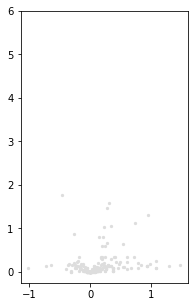

In [138]:
plt.figure(figsize=[3,5])
qval_t = -np.log10(0.05)
plt.scatter(logfc_1_m[inds_lfc_1_m],qval_1_m[inds_lfc_1_m],s=5,c="#DDDDDD")
plt.scatter(logfc_1_m[inds_up_i_mm],qval_1_m[inds_up_i_mm],s=5,c='orange')
plt.scatter(logfc_1_m[inds_down_i_mm],qval_1_m[inds_down_i_mm],s=5,c='orange')
ax = plt.gca()
plt.ylim([-0.25,6])
plt.savefig('example_data/outputs/figs/degs_nbrs_moscot.svg')